# Data exploration
1. Full models:
    - **Global** and **local** measures
    - Topological attributes. (No. dead ends , average street lenght, average campus area/perimeter...)
1. Selection of certain local areas - to discuss/agree with Mahdi.
    - **Global** and **local** measures
    - This could be created on the basis of: 
        - Surrounding/buffer areas from selected Campus categories
        - Political breaks of the city - In which case we need to get such boundaries.
1. Summarize information into tables
1. Plot and visualize the correspondant/complementary maps.
    - This will greatly differ depending on the number of them.

In [1]:
import geopandas as gpd
import pandas as pd
from numpy import log

from pyproj import CRS
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
#from shapely.wkb import dumps, loads #this is used to flatten geoms
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
#importing the text file from Depthmap
fp = "cl_data/processing_networks/netAll_sg_pr1.txt"
riyadh_fullDF = pd.read_table(fp, index_col ="Ref")
riyadh_fullDF.head(2)

,x1,y1,x2,y2,Angular Connectivity,Axial Line Ref,Connectivity,Drawing Layer,Segment Length,T1024 Choice R1200 metric,...,T1024 Integration R400 metric,T1024 Integration R800 metric,T1024 Node Count R1200 metric,T1024 Node Count R2000 metric,T1024 Node Count R400 metric,T1024 Node Count R800 metric,T1024 Total Depth R1200 metric,T1024 Total Depth R2000 metric,T1024 Total Depth R400 metric,T1024 Total Depth R800 metric
Ref,,,,,,,,,,,,,,,,,,,,,
0,677211.890215,2.732126e+06,677279.803638,2.732150e+06,3.999999,-1,4,1,72.142868,564,...,24.330618,62.644093,503,1326,51,196,1910.2969,5035.6289,106.902340,613.24219
1,667716.659819,2.737252e+06,668009.000442,2.737388e+06,2.000000,-1,2,1,322.597470,0,...,9.264240,48.730648,473,1580,13,140,1668.4258,6003.7852,18.242188,402.21094


In [40]:
# Zip the coordinates into a point object and convert to a GeoDataFrame
geom_org = [Point(xy) for xy in zip(riyadh_fullDF.x1, riyadh_fullDF.y1)]
geom_dest = [Point(xy) for xy in zip(riyadh_fullDF.x2, riyadh_fullDF.y2)]

# Creating the line segments
geom_line = [LineString([(p1.x,p1.y),(p2.x,p2.y)]) for p1, p2 in zip(geom_org,geom_dest)]
#Adding the column to the DataFrame
riyadh_fullDF["geometry"] = geom_line

#create a GeoDataFrame
riyadh_full = gpd.GeoDataFrame(riyadh_fullDF, geometry="geometry", crs=20438)

#removing unnecessary columns
cols = ['x1', 'y1', 'x2', 'y2', 'Axial Line Ref', 'Drawing Layer']
riyadh_full.drop(cols, axis = 1, inplace=True)
riyadh_full.dtypes

Angular Connectivity               float64
Connectivity                         int64
Segment Length                     float64
T1024 Choice R1200 metric            int64
T1024 Choice R2000 metric            int64
T1024 Choice R400 metric             int64
T1024 Choice R800 metric             int64
T1024 Integration R1200 metric     float64
T1024 Integration R2000 metric     float64
T1024 Integration R400 metric      float64
T1024 Integration R800 metric      float64
T1024 Node Count R1200 metric        int64
T1024 Node Count R2000 metric        int64
T1024 Node Count R400 metric         int64
T1024 Node Count R800 metric         int64
T1024 Total Depth R1200 metric     float64
T1024 Total Depth R2000 metric     float64
T1024 Total Depth R400 metric      float64
T1024 Total Depth R800 metric      float64
geometry                          geometry
dtype: object

## Function fos Syntax normalization !

In [41]:
#creating a function to normalize all syntax values
def Syntax_normalizer(df):
    
    # based on Syntax literature 
    # NaCH = logCH+1/logTD+3
    # NaIN =  NC^1.2/TD
    #extracting the useful columns
    useful_cols = [i[6:] for i in df.columns if (i[:5]=="T1024")]
    
    #extracting the radii that need to be calculated
    radii = [int(r.split()[1][1:]) for r in useful_cols if r[:6]=="Choice"]

    #creating the column names
    NaCh_colnames = ["NaCh_"+str(r) for r in radii]
    NaIn_colnames = ["NaIn_"+str(r) for r in radii]
    
    # empty dictionary to store all calculation with their keys
    normalized_dct = {}
    for rad, NaCh_col_name, NaIn_col_name in zip(radii, NaCh_colnames, NaIn_colnames):
        #slice the dataframe with relevant columns
        choice = df["T1024 Choice R%s metric" % str(rad)]
        tdepth = df["T1024 Total Depth R%s metric" % str(rad)]
        ncount = df["T1024 Node Count R%s metric" % str(rad)]

        NaCh_vals = log(choice+1) / log(tdepth+3)
        NaIn_vals = ncount**1.2 / tdepth

        normalized_dct[NaCh_col_name] = NaCh_vals
        normalized_dct[NaIn_col_name] = NaIn_vals
    
    #convert dictionary to dataframe 
    newdf = pd.DataFrame(normalized_dct)
    #join the new dataframe with the input DataFrame (based on index)
    df = df.join(newdf)
    
    print("The following columns have been added successfully:\n",NaCh_colnames,"\n",NaIn_colnames,"\n")
    return df

In [42]:
#call the new function Syntax_normalizer()
riyadh_full = Syntax_normalizer(riyadh_full)

The following columns have been added successfully:
 ['NaCh_1200', 'NaCh_2000', 'NaCh_400', 'NaCh_800'] 
 ['NaIn_1200', 'NaIn_2000', 'NaIn_400', 'NaIn_800'] 



In [43]:
#clean columns
useless_cols = ['T1024 Choice R1200 metric', 'T1024 Choice R2000 metric',
               'T1024 Choice R400 metric', 'T1024 Choice R800 metric',
               'T1024 Integration R1200 metric', 'T1024 Integration R2000 metric',
               'T1024 Integration R400 metric', 'T1024 Integration R800 metric',
               'T1024 Total Depth R1200 metric', 'T1024 Total Depth R2000 metric',
               'T1024 Total Depth R400 metric', 'T1024 Total Depth R800 metric']
riyadh_full.drop(useless_cols, axis=1, inplace = True)

riyadh_full.rename(columns={'T1024 Node Count R1200 metric': "NC_1200",
                            'T1024 Node Count R2000 metric': "NC_2000",
                            'T1024 Node Count R400 metric': "NC_400", 
                            'T1024 Node Count R800 metric': "NC_800"}, inplace=True)


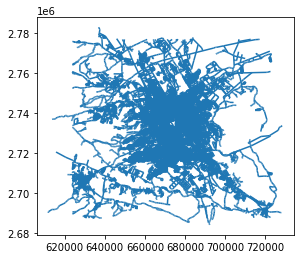

In [44]:
riyadh_full.plot()

In [46]:
fp= "cl_data/processing_networks/netAll_sg_pr1.shp"
riyadh_full.to_file(fp)

In [45]:
riyadh_full.head()

,Angular Connectivity,Connectivity,Segment Length,NC_1200,NC_2000,NC_400,NC_800,geometry,NaCh_1200,NaIn_1200,NaCh_2000,NaIn_2000,NaCh_400,NaIn_400,NaCh_800,NaIn_800
Ref,,,,,,,,,,,,,,,,
0,3.999999,4,72.142868,503,1326,51,196,"LINESTRING (677211.890 2732125.950, 677279.804...",0.838583,0.913652,0.910530,1.109171,0.701303,1.047362,0.793922,0.918492
1,2.000000,2,322.597470,473,1580,13,140,"LINESTRING (667716.660 2737252.031, 668009.000...",0.000000,0.971687,0.000000,1.148057,0.000000,1.190296,0.000000,0.935190
2,4.000000,4,361.179410,492,1738,18,164,"LINESTRING (668563.242 2735412.081, 668888.583...",0.900683,1.097474,0.888270,1.244066,0.000000,1.145160,0.804627,1.002788
3,4.035942,4,79.431976,594,1406,46,223,"LINESTRING (673497.867 2732113.537, 673509.839...",0.675590,0.940326,0.683851,1.020288,0.667290,1.065732,0.600491,0.916454
4,4.000000,4,38.248165,725,2056,70,281,"LINESTRING (672769.816 2728393.074, 672804.186...",0.680611,0.967052,0.577335,1.012421,0.619248,0.984078,0.697764,0.981902


# =================== 

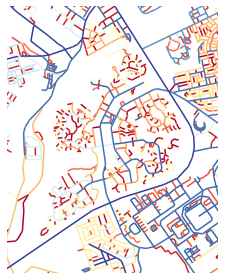

In [36]:
#bounds of one of the areas 
bbox = (662863.4908694762, 2728254.491706719, 665918.6425654521, 2732369.2887877855)
ofsett = 500

ax = riyadh_full.plot(figsize =(4,4),
                linewidth= 1.5, 
                cmap = "RdYlBu")# 
                #column = "NaCh_2000")
ax.set_xlim(bbox[0]-ofsett,bbox[2]+ofsett)
ax.set_ylim(bbox[1]-ofsett,bbox[3]+ofsett)
ax.axis("off")
plt.tight_layout()